# House Prices: Advanced Regression Techniques

## 資料前處理 (懶人法)

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

train  = pd.read_csv("./house prices/train.csv")
test = pd.read_csv("./house prices/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Data Preprocessing
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.median())
    
train["SalePrice"] = np.log1p(train["SalePrice"])

scaler = StandardScaler().fit(all_data[numeric_feats])
all_data[numeric_feats] = scaler.transform(all_data[numeric_feats])
    
#creating matrices for sklearn:
X = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

# Lasso Model

alpha = 0.000001, rmse = 0.135041
alpha = 0.000010, rmse = 0.133576
alpha = 0.000100, rmse = 0.126635
alpha = 0.001000, rmse = 0.122480
alpha = 0.010000, rmse = 0.140348
alpha = 0.100000, rmse = 0.215596
alpha = 1.000000, rmse = 0.398637


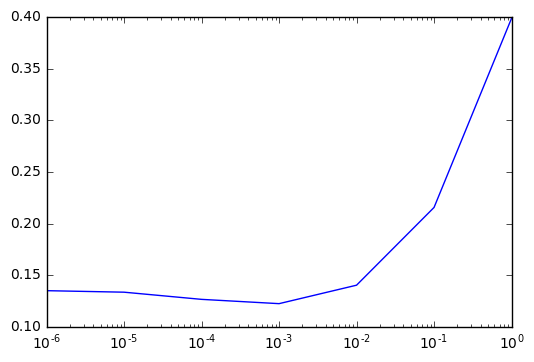

In [163]:
from sklearn.linear_model import Lasso, LassoCV
model_lasso = Lasso()

from sklearn.model_selection import cross_val_score

rmse = []

def rmse_cv(X, y):
    rmse_list = []
    alphas = []
    for alpha in np.arange(-6, 1):    
        rmse = np.sqrt(-cross_val_score(Lasso(alpha=10**alpha), X, y, scoring="neg_mean_squared_error", cv = 10))
        print 'alpha = %f, rmse = %f' % (10**alpha, rmse.mean())    
        alphas.append(10**alpha)
        rmse_list.append(rmse.mean())
    return rmse_list, alphas

rmse, alphas = rmse_cv(X, y)

cv_lasso = pd.Series(rmse, index=alphas)
cv_lasso.plot(logx=True)
plt.show()

## 確定cross-validation驗證完model後，把全部的X再拿進去train一次

In [164]:
model_lasso = Lasso(0.001)
model_lasso.fit(X, y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### alpha = 0.001000, rmse = 0.122480
### Kaggle public score = 0.12198

# NN (keras)

- 先確定有over-fitting，再去想Early Stopping, Regularization, Dropout等工具

In [165]:
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

## keras callback function

* 改寫成rmse計算方式

In [166]:
p = X.shape[1]
x_train = X.values
y_train = y.values

In [167]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(np.sqrt(logs.get('loss')))
        
        if logs.get('val_loss') == None:
            #print 'rmse loss = %f' % (np.sqrt(logs.get('loss')))
            pass
        else:
            self.val_losses.append(np.sqrt(logs.get('val_loss')))
            #print 'rmse loss = %f, val_loss = %f' % (np.sqrt(logs.get('loss')), np.sqrt(logs.get('val_loss')))

In [168]:
def nn_model(neurons=10):        
    
    print 'model: p->10->1'
    
    model = Sequential() 
    
    model.add(Dense(neurons, input_dim=p, activation='relu', name='1st hidden layer'))    
        
    model.add(Dense(1, activation='relu', name='output'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

## try 1 hidden layer, 10 neurons

In [169]:
neurons = 10
model = nn_model(neurons)
#model.summary()
#model.load_weights("weights.best.hdf5")
history = LossHistory()
model.fit(x_train, y_train, shuffle=True, nb_epoch=100, batch_size=10, validation_split=0.1, callbacks=[history], verbose=0)

model: p->10->1


### 看不出over-fitting (試過epoch1000次，也一樣)

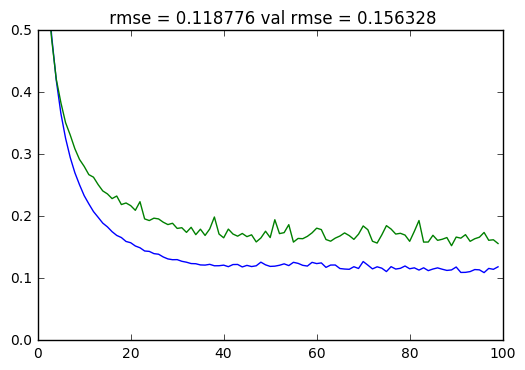

In [170]:
str1 = ' rmse = %.6f' % (float(history.losses[len(history.losses)-1]))
str2 = ' val rmse = %.6f' % (float(history.val_losses[len(history.val_losses)-1]))
plt.title(str1 + str2)
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.ylim([0, 0.5])
plt.show()

## Cross-Validation

- p.46 http://www.slideshare.net/tw_dsconf/ss-70083878
- 請問一下為何評估NN的架構沒有提到用Cross Validation K-Fold的方式
- 是否因為這整個過程太花時間，不如用直覺 + try and error能更快找到好的NN架構


- 張鈞閔
- 一般會作 cross-validation 的原因是，擔心切 training/validation set 時會有 bias，所以才作 cross-validation 來避免這種情況。
- cross-validation 是協助驗證 model 表現的穩定性，而不是在尋找好的 model。


- 你說的沒錯，要做 cross-validation 會比較好，以免錯誤評估模型 :)


- 但大多時候 training NN 遇到的問題，都不是因為 cross-validation，而是 model 的架構不適合。
- 加上 NN training 大多都需要一段時間，對一個架構就做 cross-validation <span style='color:red'>很耗時</span>，所以我傾向於:
- <span style='color:blue'>先切一份 training/validation set -> 用這份 training/validation set 找到一個好的網絡架構 -> 再做 cross-validation 驗證其穩定性。</span>

In [171]:
# build_fn的function不能有參數
estimator = KerasRegressor(build_fn=nn_model, nb_epoch=100, batch_size=10, verbose=0)
rmse_results = np.sqrt(-cross_val_score(estimator, x_train, y_train, scoring="neg_mean_squared_error", cv=10))
print "rmse: %.6f" % (rmse_results.mean())

model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
model: p->10->1
rmse: 0.163031


## 同樣確定cross-validation驗證完model後，把全部的X再拿進去train一次

### 訓練資料越多越好

In [172]:
history = LossHistory()
model = nn_model(neurons)
model.fit(x_train, y_train, shuffle=True, nb_epoch=100, batch_size=10, callbacks=[history], verbose=0)

history2 = LossHistory()
model2 = nn_model(neurons)
model2.fit(x_train, y_train, shuffle=True, nb_epoch=100, batch_size=10, validation_split=0.1, callbacks=[history2], verbose=0)

model: p->10->1
model: p->10->1


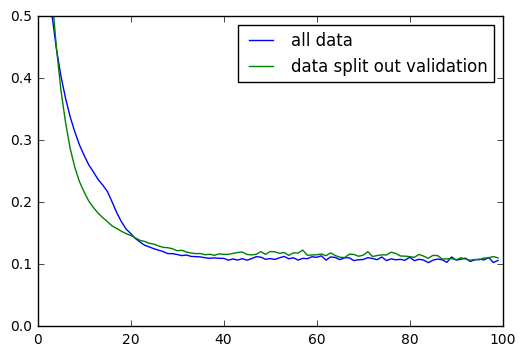

In [173]:
plt.plot(history.losses, label='all data')
plt.plot(history2.losses, label='data split out validation')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

### nn model
### cv_10, p - 10 - 1, rmse = 0.160480
### kaggle public score = 0.16617

## Early Stopping (另外一提)

- 實務上validation是鋸齒狀，實在很難抓到停止的點
- 另一種方式是用keras的ModelCheckpoint，把最小的validation結果存起來

In [174]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model = nn_model(neurons)
history = LossHistory()
hist = model.fit(x_train, y_train, nb_epoch=100, batch_size=10, validation_split=0.2, callbacks=[history, checkpoint], verbose=0)

model: p->10->1


## 在還沒搞懂cross-validation真正含意前，我try and error好幾個nn model

## <span style='color:blue'>先切一份 training/validation set -> 用這份 training/validation set 找到一個好的網絡架構 -> 再做 cross-validation 驗證其穩定性。</span>

## 其他NN model練習 (有點亂試一通)

- NN Model應該從簡單的開始試
- 底下這些Model好像都看不到over-fitting???

- Training結果不好，再來考慮換Activation Function
- <span style='color:red'>當你Validation的結果變差的時候，再來考慮用EarlyStopping, Regularization, Dropout</span>

- 1 hidden
![alt tag](https://github.com/JiaMauJian/data-analysis/blob/master/house%20prices/1%20hidden.png?raw=true)
- 2 hidden
![alt tag](https://github.com/JiaMauJian/data-analysis/blob/master/house%20prices/2%20hidden.png?raw=true)
- 3 hidden
![alt tag](https://github.com/JiaMauJian/data-analysis/blob/master/house%20prices/3%20hidden.png?raw=true)
- 3 hidden + dropput 
- 為什麼dropout在training結果上比較差? (http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/DNN%20tip.pdf#page=38)
- 聽Youtube比較清楚
- Training做好了，再去想怎麼把Testing做好
![alt tag](https://github.com/JiaMauJian/data-analysis/blob/master/house%20prices/dropout.png?raw=true)

## 胡亂試了3層hidden layer, 100 neurons, dropout一下
## 這樣分數可以衝到public score = 0.12003

- hidden layer = 3
- dropout = 0.01
- preds = 0.7*lasso_pred + 0.3*dnn_pred



## output (把Lasso和NN加在一起)

In [175]:
lasso_pred = np.expm1(model_lasso.predict(X_test))
dnn_pred = np.expm1(model.predict(X_test.values))
dnn_pred = dnn_pred[:, 0]

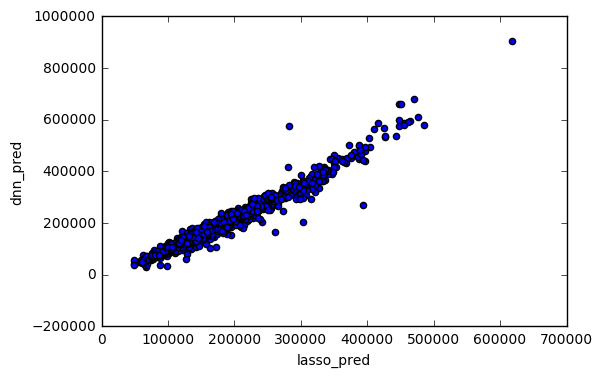

In [176]:
df = pd.DataFrame({"lasso_pred":lasso_pred,"dnn_pred":dnn_pred})
df.plot(x = "lasso_pred", y = "dnn_pred", kind = "scatter")
plt.show()

## 0.7的lasso配0.3的nn 分數是最好的 (神奇)

- 試過0.5+0.5或是0.3 lasso + 0.7nn 都沒比較好

In [177]:
preds = 0.7*lasso_pred + 0.3*dnn_pred

pred_df = pd.DataFrame(preds, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')